# 0. 분석 방향
* 예측은 **유저별** 생존 기간, 평균 결제 금액이기 때문에 유저별로 groupby를 어떻게 진행할지에 관점을 두고 볼 것이다.
* train, test1, test2의 데이터 분포와 통계치를 확인할 것이다.<BR>(train을 학습하여 test1과 test2를 예측하는데 데이터 간의 분포와 통계치가 많은 차이가 있을 경우 예측에 도움이 안될 것이다.)

# 1. 도입(라이브러리, 데이터 로딩)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)

import missingno as msno
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy as sp

import warnings
warnings.filterwarnings('ignore')
from collections import OrderedDict
     
import os
%matplotlib inline

pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2f}'.format

In [2]:
os.chdir('..') #상위디렉터리로 이동
path_dir = os.getcwd()+"/champions/"
file_list = sorted(os.listdir(path_dir))

data_dict = OrderedDict()
for file in file_list:
    if file.find('csv') is not -1:
        if file.split('_')[1] == 'payment.csv':
            data_dict[file.split('.')[0]] = pd.read_csv(path_dir+file)

## 1.1 자료 구분값 추가(load 파일 구분)

In [3]:
data_dict['train_payment']['kind'] = 'train'
data_dict['test1_payment']['kind'] = 'test1'
data_dict['test2_payment']['kind'] = 'test2'
data_dict['train_payment']['kind_int'] = 1
data_dict['test1_payment']['kind_int'] = 2
data_dict['test2_payment']['kind_int'] = 3

payment_all = data_dict['train_payment'].append(data_dict['test1_payment'])
del(data_dict['train_payment'])
del(data_dict['test1_payment'])
payment_all = payment_all.append(data_dict['test2_payment'])
del(data_dict['test2_payment'])

In [4]:
payment_all.shape

(116891, 5)

In [5]:
payment_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116891 entries, 0 to 25629
Data columns (total 5 columns):
day             116891 non-null int64
acc_id          116891 non-null int64
amount_spent    116891 non-null float64
kind            116891 non-null object
kind_int        116891 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 5.4+ MB


In [6]:
payment_all.isna().sum()

day             0
acc_id          0
amount_spent    0
kind            0
kind_int        0
dtype: int64

In [10]:
payment_all.head()

,day,acc_id,amount_spent,kind,kind_int
0,18,27835,0.83,train,1
1,23,27835,0.01,train,1
2,27,27835,0.04,train,1
3,17,12351,0.53,train,1
4,11,125437,0.63,train,1


# 2. 탐색적 자료 분석

## 2.1 int, float64 자료형 변수 train, test1, test2 분포 확인

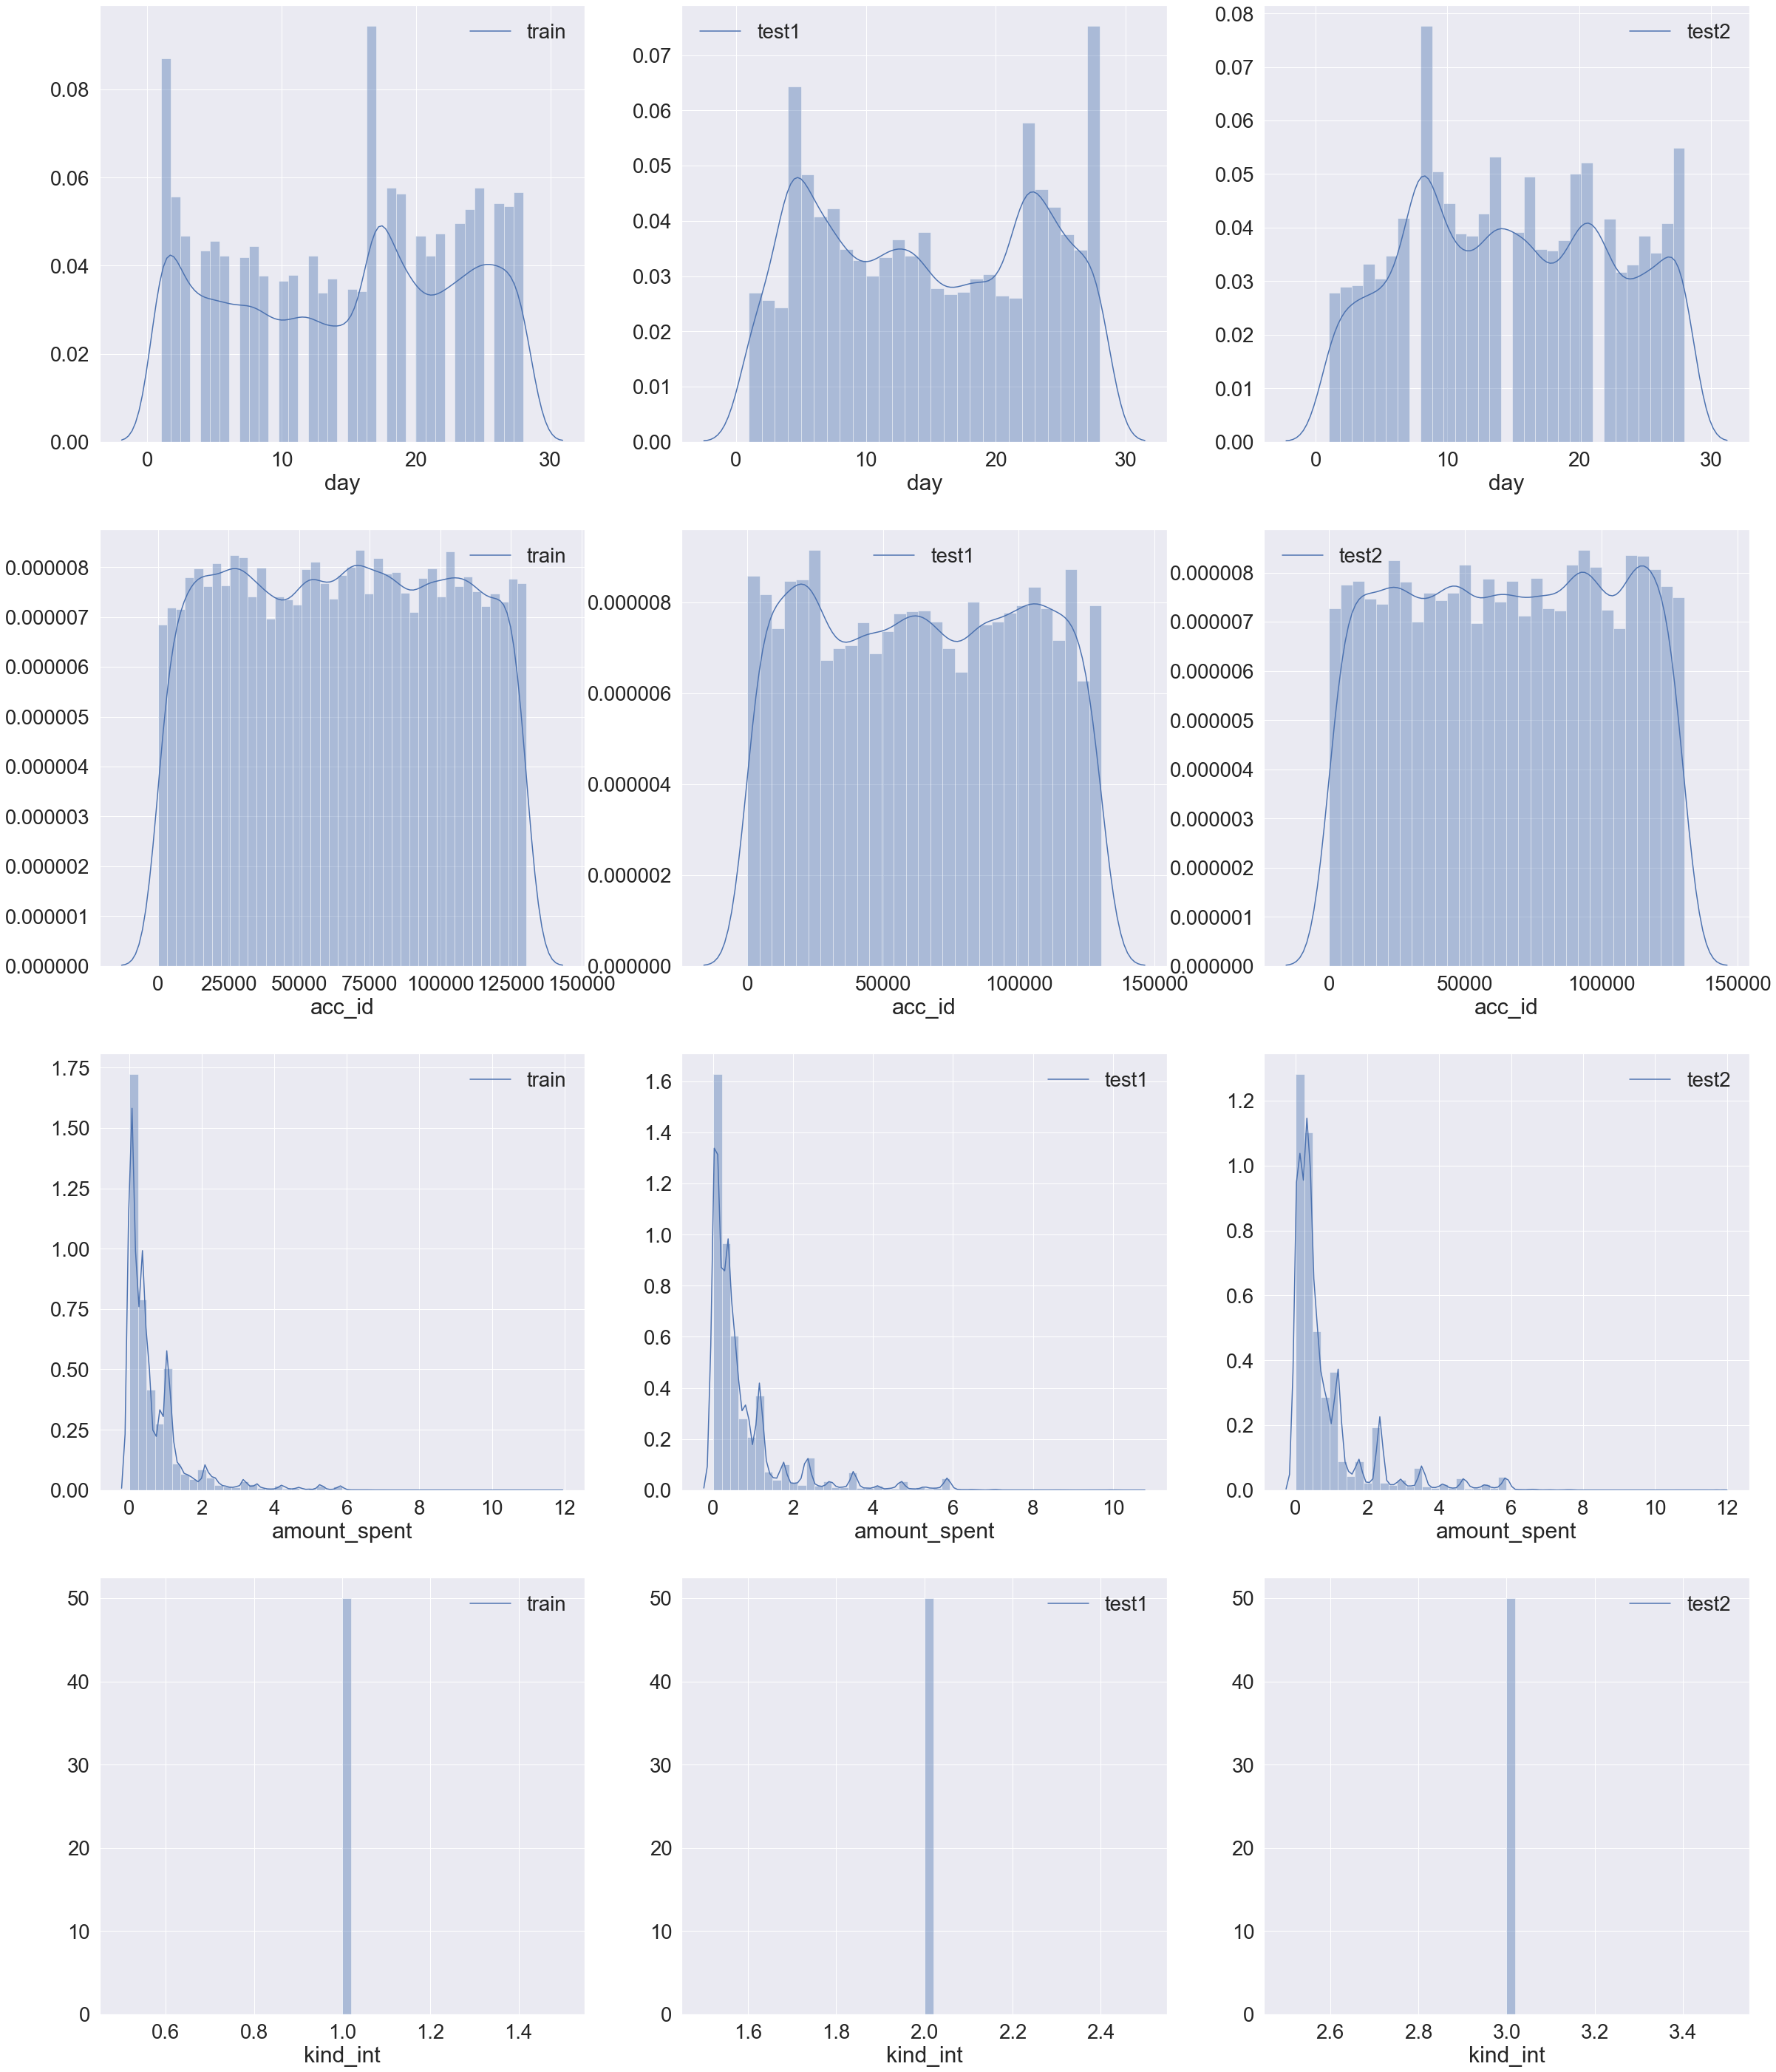

In [7]:
f = len(payment_all.select_dtypes(include={'int64','float64'}).keys())
ax = len(payment_all['kind'].unique())

f, ax = plt.subplots(f, ax,figsize=(40,50))
row = 0
for payment_all_keys in payment_all.select_dtypes(include={'int64','float64'}).keys():
    col = 0
    for type_keys in payment_all['kind'].unique():
        sns.distplot(
            payment_all[payment_all['kind'] == type_keys][payment_all_keys],
            ax=ax[row][col],
            kde_kws={"label":type_keys}
        )
        col = col+1
    row = row+1

## 2.2 int, float64 자료형 변수 train, test1, test2 통계치 확인

In [8]:
payment_all[payment_all.select_dtypes(include={'int64','float64'}).keys()].groupby('kind_int').describe().T

kind_int                   1         2         3
day          count  66432.00  24829.00  25630.00
             mean      14.71     14.59     14.87
             std        8.48      8.24      7.77
             min        1.00      1.00      1.00
             25%        7.00      7.00      8.00
             50%       16.00     14.00     15.00
             75%       22.00     22.00     21.00
             max       28.00     28.00     28.00
acc_id       count  66432.00  24829.00  25630.00
             mean   65352.58  64662.03  65653.93
             std    37413.40  38117.76  37757.36
             min        8.00      7.00      1.00
             25%    32646.00  30430.00  32856.00
             50%    65709.00  64560.00  65789.00
             75%    97500.25  98333.00  98394.00
             max   130473.00 130474.00 130471.00
amount_spent count  66432.00  24829.00  25630.00
             mean       0.67      0.77      0.84
             std        0.91      1.09      1.12
             min        0.01      0.01      0.01
             25%        0.11      0.12      0.18
             50%        0.35      0.35      0.37
             75%        0.95      0.88      1.05
             max       11.73     10.56     11.73

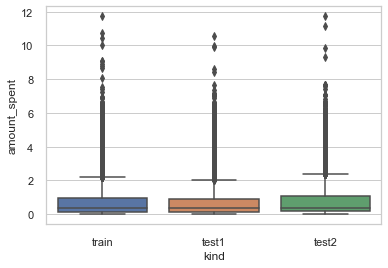

In [9]:
payment_all_attention = ['amount_spent']
sns.set(style="whitegrid")
for payment_all_attention_keys in payment_all_attention:
    sns.boxplot(
        x="kind", 
        y=payment_all_attention_keys, 
        data=payment_all
    )
    plt.show()

* 대략 비슷한 것을 알 수 있음.

# 3. Feature Engineering

**FE를 통해 추가한 변수 리스트**

* 기록된 day 변수의 개수와 리스트
    * **day_concat_count** : 개수
    * **day_concat_detail** : 리스트
* 데이터 로드한 위치(train, test1, test2)의 개수와 리스트
    * **kind_concat_count** : 개수
    * **kind_concat_detail** : 리스트
* **amount_spent_mean** : 평균결제금액
